# Predicting the Stock Market through LSTM Regression

## Import and Data Loading

In [ ]:
import os
from sklearn.preprocessing import MinMaxScaler
from google.colab import drive
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Mount to the data
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/ML_Datasets')

# Confirm we're in the correct drive
print(os.listdir())

sp = pd.read_csv('SP500_sentiment.csv').dropna(subset=['Close/Last'])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['mnist_test.csv', 'mnist_train.csv', 'checkpoints', 'SP500.csv', 'batch1.h5', 'batch1.keras', 'SP500_sentiment.csv']


## Hyperparameters

In [ ]:
window_size = 50 # @param {type:"number"}
shift = 1 # @param {type:"number"}
label_width = 1 # @param {type:"number"}
train_perc = 0.75 # @param {type:"number"}
valid_perc = 0.15 # @param {type:"number"}
test_perc = 1 - (train_perc + valid_perc)

batch_size = 30 # @param {type:"number"}
epochs = 100 # @param {type:"number"}
units = 55  # @param {type:"number"}

## Data Preprocessing

### Data Extraction & Splitting

In [ ]:
# Extract closing prices from the SP500 dataset (MAKING SURE TO REVERSE IT)
prices = np.array(sp['Close/Last'])
sentiment = np.array(sp['Sentiment'])

combined_data = []
for i, price in enumerate(prices):
  combined_data.append((price, sentiment[i]))

# Split our data
n = len(combined_data)
train_df = combined_data[:int(n * train_perc)]
valid_df = combined_data[int(n*train_perc):int(n * (train_perc + valid_perc))]
test_df = combined_data[int(n*(train_perc + valid_perc)):]

### Data Window Normalisation

In [ ]:
# Represents a normalised winow, keeping track of the scaler used to normalise
# and denormalise a window, and the inputs and labels of the window
class NormalisedPriceWindow():
  def __init__(self, winputs, wlabels, wscaler):
    self.winputs = winputs
    self.wlabels = wlabels
    self.wscaler = wscaler

# Generates windows and handles the normalisation and denormalisation of windows
class WindowManager():

  def __init__(self, input_width=window_size, label_width=label_width, shift=shift,
               train_df=train_df, valid_df=valid_df, test_df=test_df):
    # Store the raw data
    self.prices_train_df = [x for (x, y) in train_df]
    self.prices_valid_df = [x for (x, y) in valid_df]
    self.prices_test_df = [x for (x, y) in test_df]
    self.sentiment_train_df = [y for (x, y) in train_df]
    self.sentiment_valid_df = [y for (x, y) in valid_df]
    self.sentiment_test_df = [y for (x, y) in test_df]

    # Work out the window parameters
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift
    self.total_window_size = input_width + label_width

    # Create the windows with price and sentiment
    self.price_train_windows = self.create_price_windows(self.prices_train_df)
    self.price_valid_windows = self.create_price_windows(self.prices_valid_df)
    self.price_test_windows = self.create_price_windows(self.prices_test_df)
    self.sentiment_train_windows = self.create_sentiment_windows(self.sentiment_train_df)
    self.sentiment_valid_windows = self.create_sentiment_windows(self.sentiment_valid_df)
    self.sentiment_test_windows = self.create_sentiment_windows(self.sentiment_test_df)

    # Normalise the price windows
    self.normal_train_windows = self.normalise_window(self.price_train_windows)
    self.normal_valid_windows = self.normalise_window(self.price_valid_windows)
    self.normal_test_windows = self.normalise_window(self.price_test_windows)

    # Simple test for checking correct denormalisation
    # self.d_test = self.denormalise_window(self.normal_train_windows)

  # Creates windows from our raw data
  def create_price_windows(self, raw_data):
    # Store created windows
    windows = []

    # Manually perform windowing, taking shift into account
    curr_shift = 0
    while curr_shift < len(raw_data) - self.total_window_size:
      # Get the window input data
      input_data = raw_data[curr_shift:curr_shift + self.input_width]
      # Get the window label data
      label_data = raw_data[curr_shift + self.input_width:curr_shift + self.total_window_size]

      # Save the created window
      windows.append((input_data, label_data))

      # Go to the next shift
      curr_shift += shift

    return windows

  def create_sentiment_windows(self, raw_data):
    # Store created windows
    windows = []

    # Manually perform windowing, taking shift into account
    curr_shift = 0
    while curr_shift < len(raw_data) - self.total_window_size:
      windows.append(raw_data[curr_shift : curr_shift + self.input_width])
      curr_shift += shift

    return windows

  # Normalises our windows
  def normalise_window(self, windows):
    # Join the window's inputs and labels
    joined_windows = [np.append(x, y) for (x, y) in windows]

    # Reshape and perform minmaxscaler on each window individually
    normalised_windows = []
    for i, window in enumerate(joined_windows):
      scaler = MinMaxScaler(feature_range=(0, 1))
      transformed_values = scaler.fit_transform(window.reshape(-1, 1)).reshape(-1)
      normalised_windows.append(NormalisedPriceWindow(transformed_values[:self.input_width], transformed_values[self.input_width:], scaler))

    return normalised_windows

  # Denormalise our windows

  # This joins results with the input values they were predicted from, and
  # denormalises them together.
  def denormalise_results(self, inputs, results, scalers):

    # Join the inputs and results
    joined_values = []
    for i, values in enumerate(inputs):
      joined_values.append(np.append(values, results[i]))

    # Denormalise the joined values
    output = []
    for i, values in enumerate(joined_values):
      scaler = scalers[i]
      denorm_values = scaler.inverse_transform(values.reshape(-1, 1)).reshape(-1)
      output.append(denorm_values[-1])

    return output

  # Method that simply denormalises a normalised window to check that the values
  # are correct
  def denormalise_window(self, normalised_windows):

    output = []
    for window in normalised_windows:
      values = np.append(window.winputs, window.wlabels)
      tmp = window.wscaler.inverse_transform(values.reshape(-1, 1))
      tmp = tmp.reshape(-1)
      output.append(tmp)

    return output

# Create a Window Manager instance
window_manager = WindowManager()

## Model Architecture

### Defining the Model Architecture

In [ ]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(units, return_sequences=True, input_shape=(window_size, 2)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(units, return_sequences=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=1)
])

# Tensorflow has no built-in RMSE loss function - have to define our own
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

lstm_model.compile(optimizer='adam', loss='mean_squared_error', metrics=[tf.keras.metrics.MeanSquaredError(name="MSE"), tf.keras.metrics.RootMeanSquaredError(name="RMSE"), tf.keras.metrics.R2Score(name="R2")])

## Training the Model

In [ ]:
# Extract our training data
train_inputs = []
for i, n_window in enumerate(window_manager.normal_train_windows):
  tmp_window = []
  for j, winput in enumerate(n_window.winputs):
    tmp_window.append((winput, window_manager.sentiment_train_windows[i][j]))
  train_inputs.append(tmp_window)
train_inputs = np.array(train_inputs)

train_labels = np.array([n_window.wlabels for n_window in window_manager.normal_train_windows])

# Extract our validation data
valid_inputs = []
for i, n_window in enumerate(window_manager.normal_valid_windows):
  tmp_window = []
  for j, winput in enumerate(n_window.winputs):
    tmp_window.append((winput, window_manager.sentiment_valid_windows[i][j]))
  valid_inputs.append(tmp_window)
valid_inputs = np.array(valid_inputs)

valid_labels = np.array([n_window.wlabels for n_window in window_manager.normal_valid_windows])

# Extract our testing data
test_inputs = []
for i, n_window in enumerate(window_manager.normal_test_windows):
  tmp_window = []
  for j, winput in enumerate(n_window.winputs):
    tmp_window.append((winput, window_manager.sentiment_test_windows[i][j]))
  test_inputs.append(tmp_window)
test_inputs = np.array(test_inputs)

test_labels = np.array([n_window.wlabels for n_window in window_manager.normal_test_windows])

# Train our model
history = lstm_model.fit(train_inputs, train_labels,
                         batch_size=batch_size,
                         epochs=epochs,
                         validation_data=(valid_inputs, valid_labels))

Epoch 1/100
25/25 [==============================] - 4s 41ms/step - loss: 0.1010 - MSE: 0.1010 - RMSE: 0.3179 - R2: -0.2065 - val_loss: 0.0606 - val_MSE: 0.0606 - val_RMSE: 0.2462 - val_R2: 0.0278
Epoch 2/100
25/25 [==============================] - 0s 9ms/step - loss: 0.0630 - MSE: 0.0630 - RMSE: 0.2509 - R2: 0.2482 - val_loss: 0.0353 - val_MSE: 0.0353 - val_RMSE: 0.1878 - val_R2: 0.4345
Epoch 3/100
25/25 [==============================] - 0s 9ms/step - loss: 0.0478 - MSE: 0.0478 - RMSE: 0.2187 - R2: 0.4289 - val_loss: 0.0317 - val_MSE: 0.0317 - val_RMSE: 0.1779 - val_R2: 0.4923
Epoch 4/100
25/25 [==============================] - 0s 9ms/step - loss: 0.0391 - MSE: 0.0391 - RMSE: 0.1978 - R2: 0.5330 - val_loss: 0.0259 - val_MSE: 0.0259 - val_RMSE: 0.1610 - val_R2: 0.5844
Epoch 5/100
25/25 [==============================] - 0s 9ms/step - loss: 0.0387 - MSE: 0.0387 - RMSE: 0.1967 - R2: 0.5381 - val_loss: 0.0231 - val_MSE: 0.0231 - val_RMSE: 0.1519 - val_R2: 0.6298
Epoch 6/100
25/25 [====

## Qualitative Analysis


### Extracted Prices and Sentiment

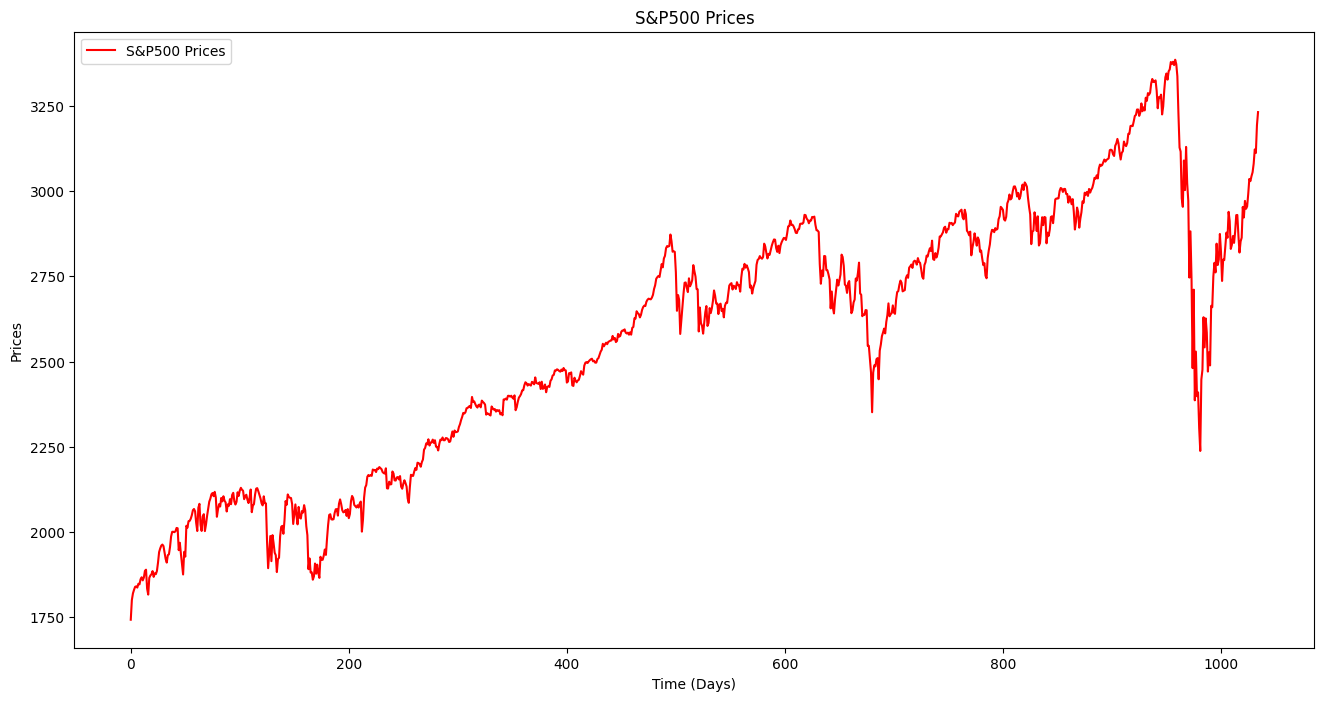

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(prices, color='red', label='S&P500 Prices')
plt.title('S&P500 Prices')
plt.xlabel('Time (Days)')
plt.ylabel('Prices')
plt.legend()
plt.show()

# fig, axs = plt.subplots(1, 2, figsize=(22,10))

# axs[0].plot(prices, color='red')
# axs[0].set_title('S&P500 Prices')
# axs[0].set_xlabel('Time (Days)')
# axs[0].set_ylabel('Price')

# axs[1].plot(sentiment)
# axs[1].set_title('S&P500 Sentiment')
# axs[1].set_xlabel('Time (Days)')
# axs[1].set_ylabel('Sentiment')

# plt.tight_layout()

# plt.show()

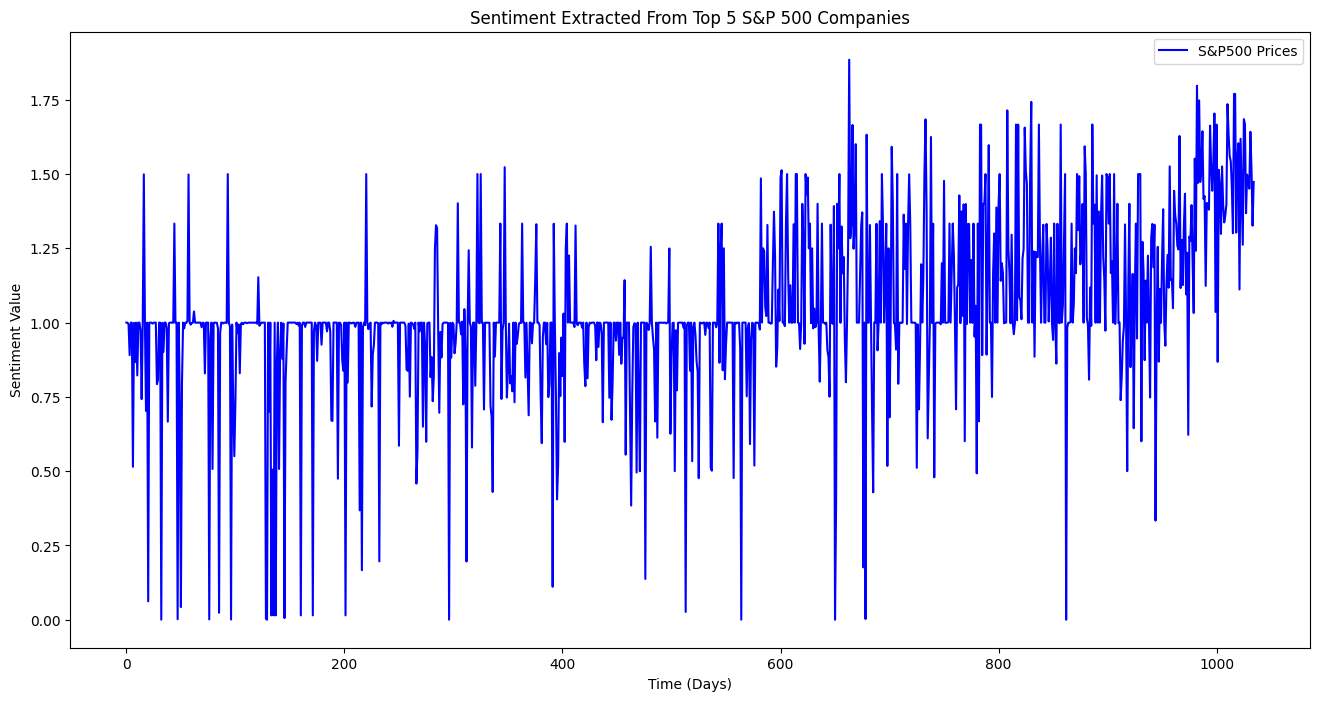

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(sentiment, color='blue', label='S&P500 Prices')
plt.title('Sentiment Extracted From Top 5 S&P 500 Companies')
plt.xlabel('Time (Days)')
plt.ylabel('Sentiment Value')
plt.legend()
plt.show()

### Distribution of Pre-Normalised Data

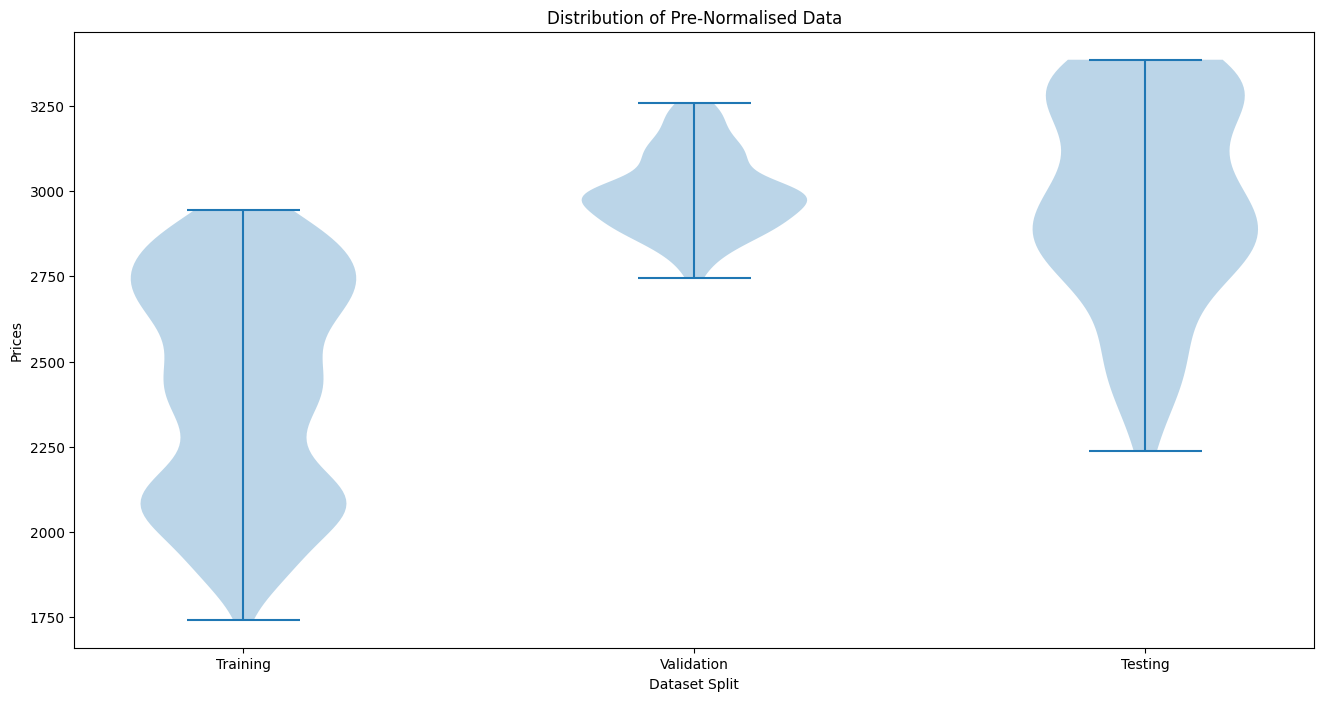

In [ ]:
price_dis1 = [x for (x, y) in train_df]
price_dis2 = [x for (x, y) in valid_df]
price_dis3 = [x for (x, y) in test_df]
plt.figure(figsize=(16,8))
plt.violinplot([price_dis1, price_dis2, price_dis3])
plt.xticks([1, 2, 3], ['Training', 'Validation', 'Testing'])
plt.xlabel('Dataset Split')
plt.ylabel('Prices')
plt.title('Distribution of Pre-Normalised Data')
plt.show()

### Distribution of Normalised Data

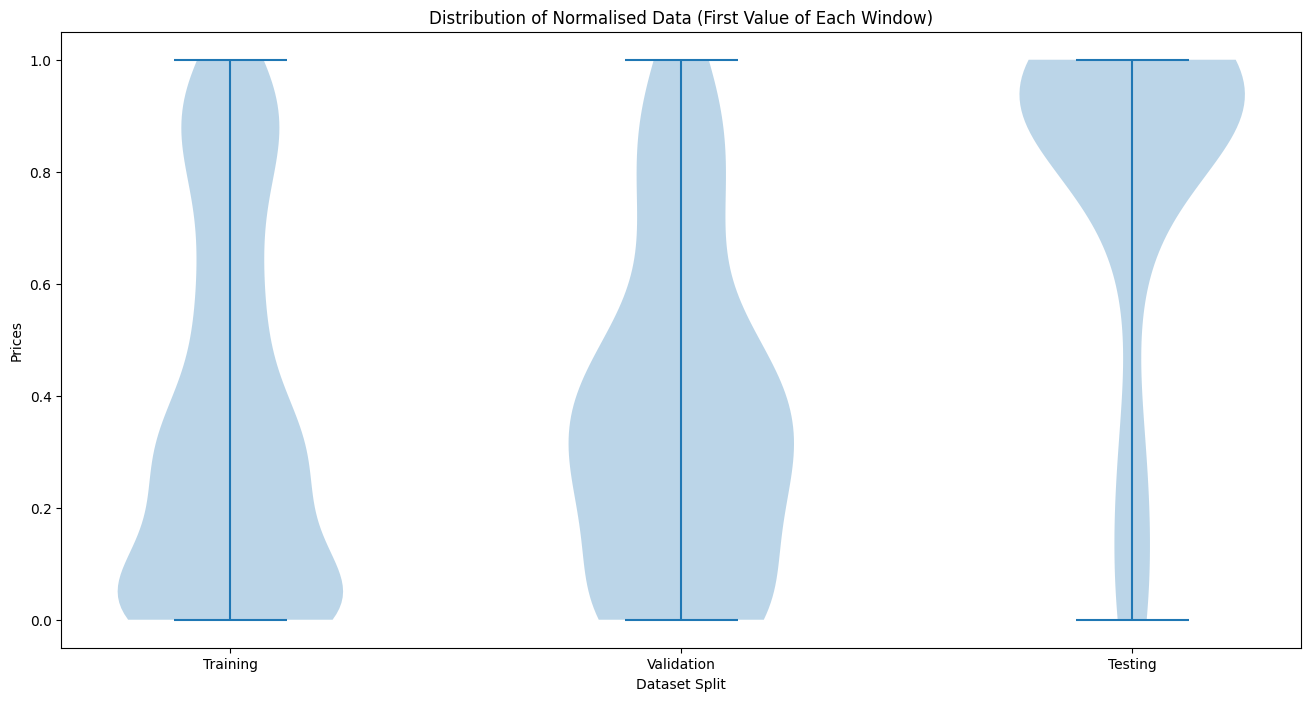

In [ ]:
tr = [values.winputs[0] for values in window_manager.normal_train_windows]
va = [values.winputs[0] for values in window_manager.normal_valid_windows]
te = [values.winputs[0] for values in window_manager.normal_test_windows]

# Combine input and label data
plt.figure(figsize=(16,8))
plt.violinplot([tr, va, te])
plt.xticks([1, 2, 3], ['Training', 'Validation', 'Testing'])
plt.xlabel('Dataset Split')
plt.ylabel('Prices')
plt.title('Distribution of Normalised Data (First Value of Each Window)')
plt.show()

### Training Metrics

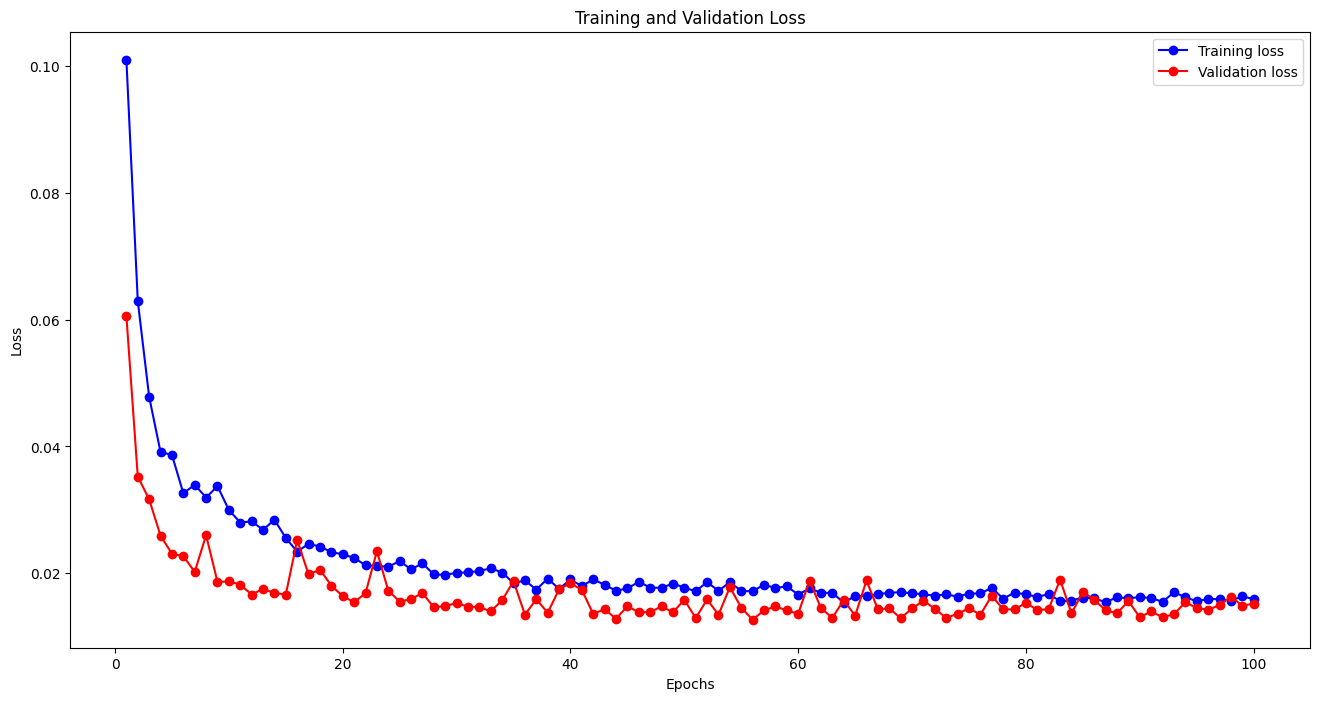

In [ ]:
# Extracting the data (LOSS)
epochs_his = range(1, len(history.history['loss']) + 1)
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Creating subplots for loss and accuracy
plt.figure(figsize=(16, 8))

# Plotting training and validation loss
plt.plot(epochs_his, train_loss, 'bo-', label='Training loss')
plt.plot(epochs_his, val_loss, 'ro-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Display the plots
plt.show()

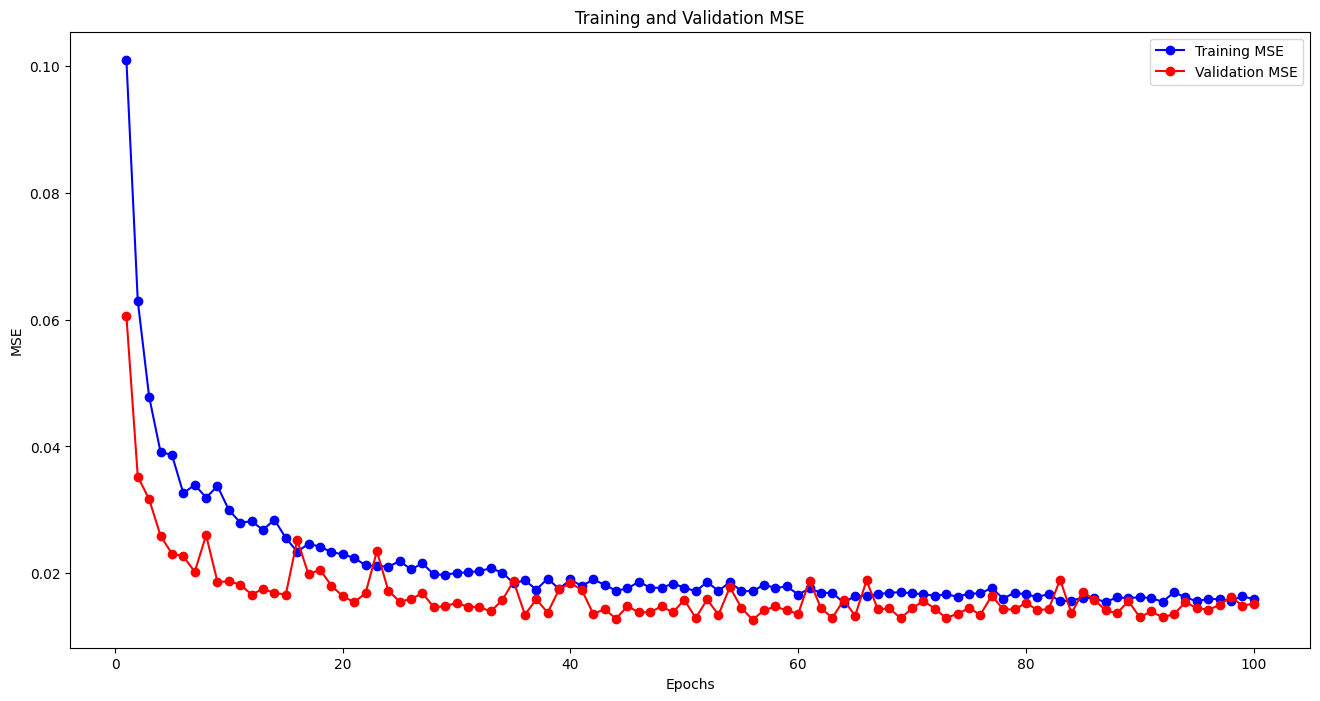

In [ ]:
# Extracting the data (MSE)
train_MSE = history.history['MSE']
val_MSE = history.history['val_MSE']

# Creating subplots for loss and accuracy
plt.figure(figsize=(16, 8))

# Plotting training and validation loss
plt.plot(epochs_his, train_MSE, 'bo-', label='Training MSE')
plt.plot(epochs_his, val_MSE, 'ro-', label='Validation MSE')
plt.title('Training and Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()

# Display the plots
plt.show()

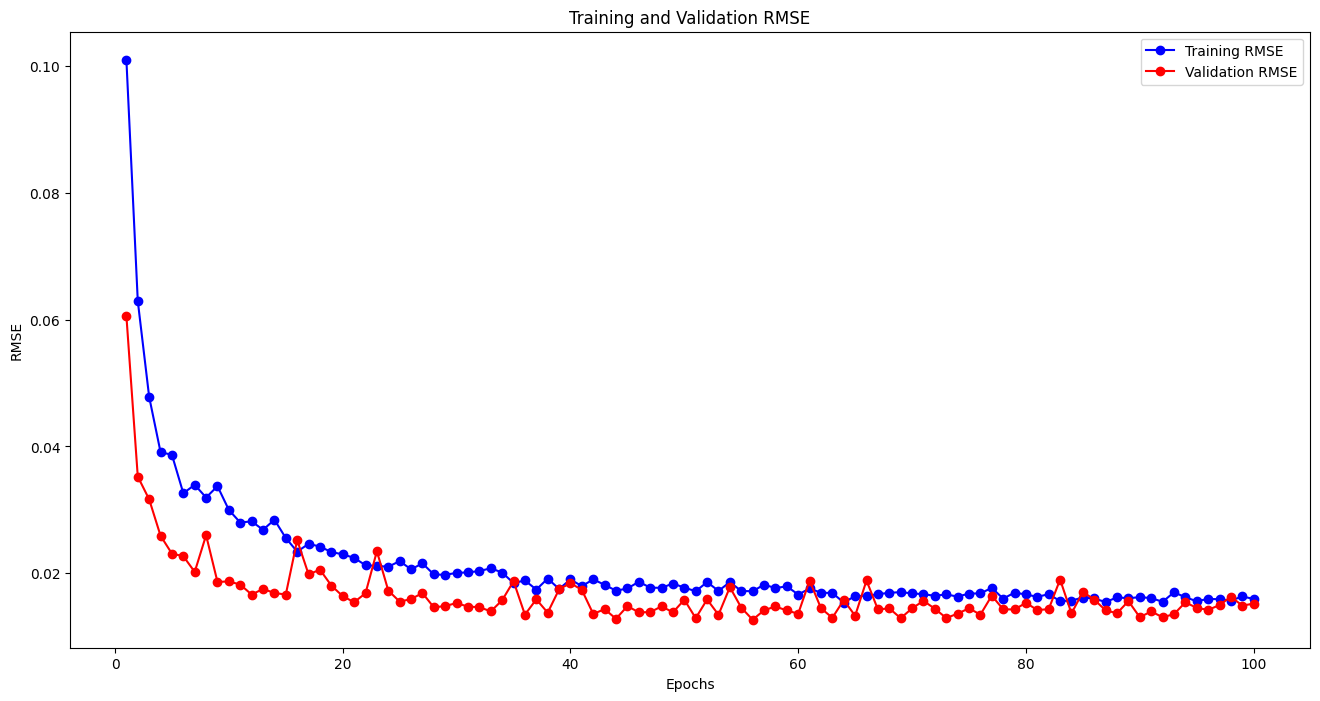

In [ ]:
# Extracting the data (RMSE)
train_RMSE = history.history['RMSE']
val_RMSE = history.history['val_RMSE']

# Creating subplots for loss and accuracy
plt.figure(figsize=(16, 8))

# Plotting training and validation loss
plt.plot(epochs_his, train_MSE, 'bo-', label='Training RMSE')
plt.plot(epochs_his, val_MSE, 'ro-', label='Validation RMSE')
plt.title('Training and Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()

# Display the plots
plt.show()

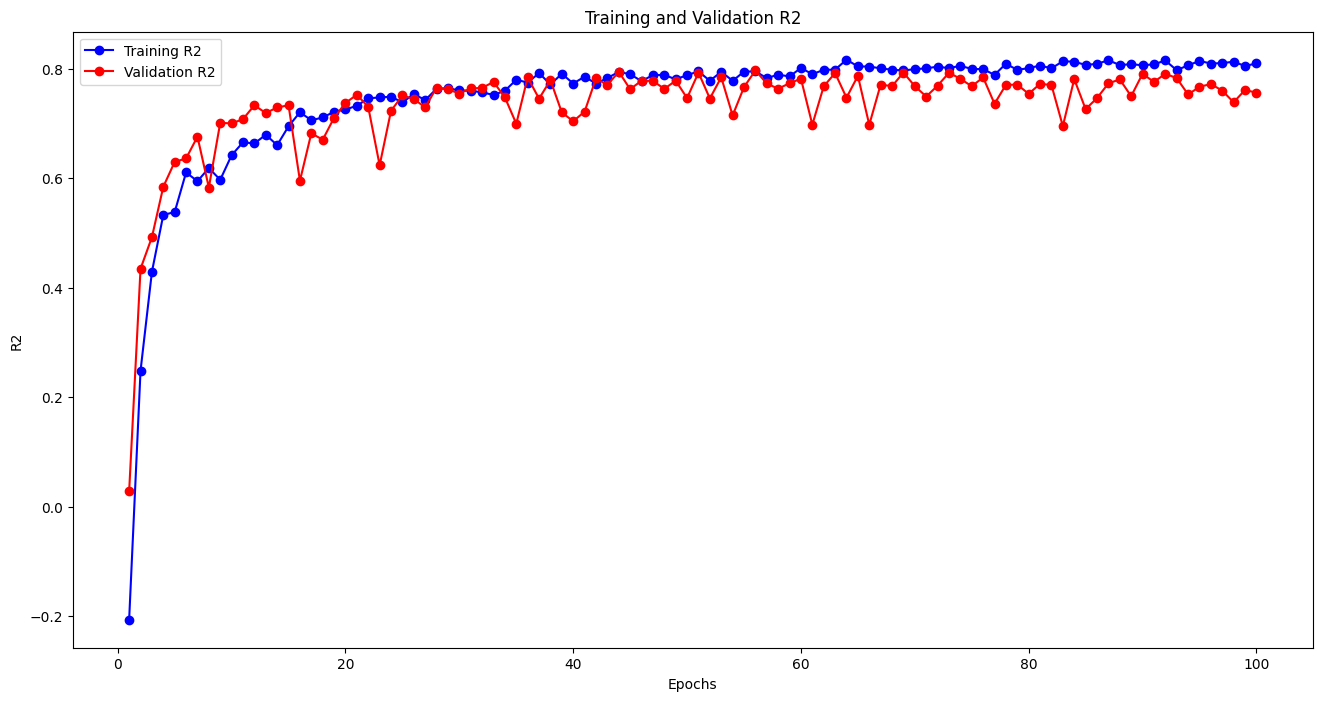

In [ ]:
# Extracting the data (R2)
train_R2 = history.history['R2']
val_R2 = history.history['val_R2']

# Creating subplots for loss and accuracy
plt.figure(figsize=(16, 8))

# Plotting training and validation loss
plt.plot(epochs_his, train_R2, 'bo-', label='Training R2')
plt.plot(epochs_his, val_R2, 'ro-', label='Validation R2')
plt.title('Training and Validation R2')
plt.xlabel('Epochs')
plt.ylabel('R2')
plt.legend()

# Display the plots
plt.show()

### Test Data Predictions

2/2 [==============================] - 1s 7ms/step


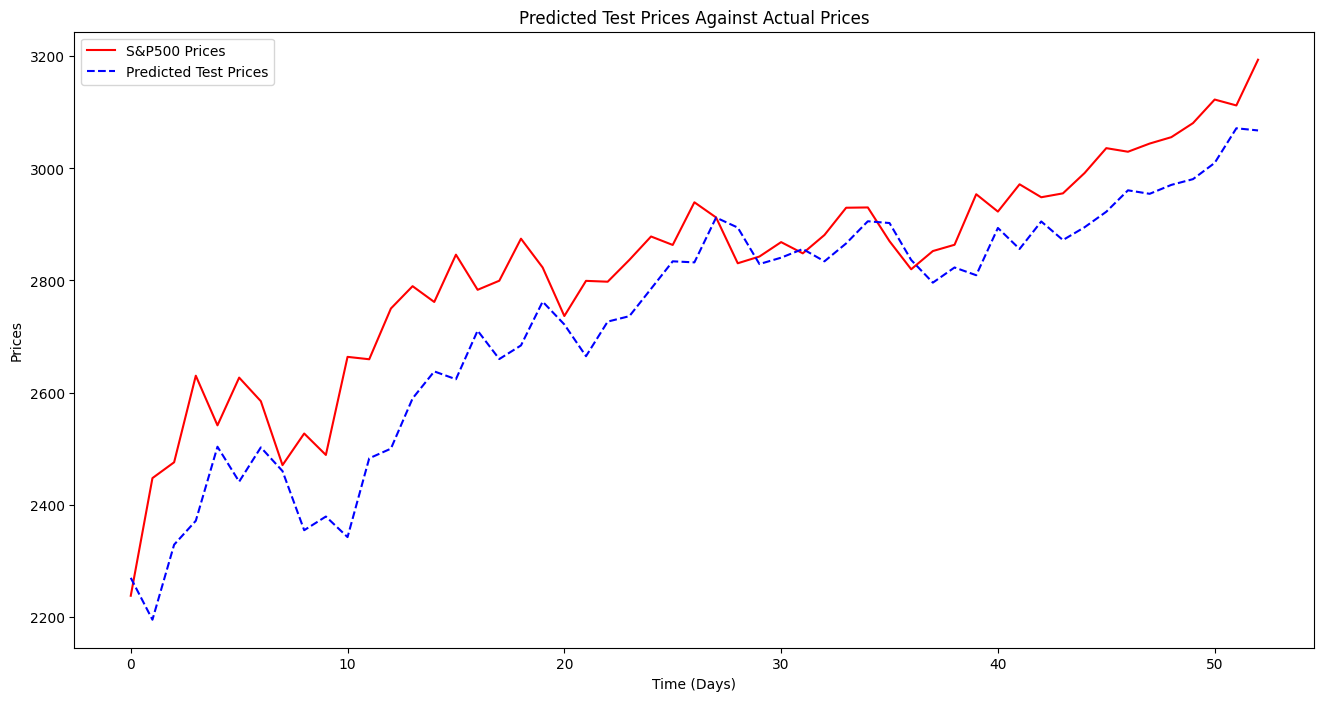

In [ ]:
# Perform Inferences using our test data
predicted_values = lstm_model.predict(test_inputs).reshape(-1)
# Extract the scalers from our test data to denormalise our results
scalers = [window.wscaler for window in window_manager.normal_test_windows]
# Denormalise the results
denorm_results = window_manager.denormalise_results(test_inputs, predicted_values, scalers)

# Extract the actual test data pre-normalisation to plot predicted values against
test_values = [y for (x, y) in window_manager.price_test_windows]

plt.figure(figsize=(16,8))
plt.plot(test_values, color='red', label='S&P500 Prices')
plt.plot(denorm_results, color='blue', linestyle='--', label='Predicted Test Prices')
# plt.plot(denorm_results[1:], color='blue', linestyle='--', label='Predicted Test Prices')
# plt.plot(test_values[:-1], color='red', label='S&P500 Prices')
plt.title('Predicted Test Prices Against Actual Prices')
plt.xlabel('Time (Days)')
plt.ylabel('Prices')
plt.legend()
plt.show()

## Misc

In [ ]:
# # Test to see if we're capturing all data in our split
print(f"DATA SPLIT:\n\tTraining #: {len(train_df)}\n\tValidation #: {len(valid_df)}\n\tTesting #: {len(test_df)}\n\tTotal #: {len(train_df) + len(valid_df) + len(test_df)}\n\tOriginal #: {len(prices)}")

print(window_manager.prices_train_df)
print(window_manager.sentiment_train_df)

print(window_manager.price_train_windows)
print(window_manager.sentiment_train_windows)
print(len(window_manager.price_train_windows))
print(len(window_manager.sentiment_train_windows))

print(train_inputs[0])

print(lstm_model.summary())


DATA SPLIT:
	Training #: 776
	Validation #: 155
	Testing #: 104
	Total #: 1035
	Original #: 1035
[1741.89, 1799.84, 1819.26, 1829.83, 1838.63, 1839.78, 1836.25, 1847.61, 1845.73, 1860.77, 1866.52, 1857.44, 1865.62, 1885.52, 1888.77, 1833.08, 1815.69, 1864.85, 1871.89, 1875.39, 1884.66, 1867.72, 1878.21, 1875.63, 1885.08, 1909.78, 1940.46, 1951.27, 1959.48, 1962.61, 1958.12, 1938.99, 1920.21, 1909.57, 1931.59, 1933.75, 1955.18, 1986.51, 2000.02, 2000.12, 1998.98, 2001.57, 2011.36, 2010.4, 1946.17, 1967.9, 1935.1, 1906.13, 1874.74, 1941.28, 1927.11, 2017.81, 2012.1, 2031.21, 2031.92, 2038.25, 2048.72, 2063.5, 2067.03, 2060.31, 2026.14, 2002.33, 2070.65, 2082.17, 2020.58, 2002.61, 2044.81, 2051.82, 2002.16, 2021.25, 2046.74, 2068.53, 2088.48, 2097.45, 2110.3, 2113.86, 2104.5, 2117.39, 2101.04, 2044.16, 2065.95, 2081.19, 2074.28, 2099.5, 2089.27, 2104.42, 2091.5, 2086.24, 2059.69, 2080.62, 2076.33, 2095.84, 2081.18, 2108.29, 2114.49, 2089.46, 2080.15, 2088.0, 2116.1, 2105.33, 2121.1, 2129.